In [82]:
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing 
from collections import defaultdict

In [2]:
df1 = pd.DataFrame(pd.read_csv('./data/ijcai2016_taobao.csv',header=0))


In [4]:
df1[:100]

,use_ID,sel_ID,ite_ID,cat_ID,act_ID,time
0,1980536,9666,1450952,1,0,20150826
1,1980536,9666,1450952,1,0,20150826
2,647747,9666,1450952,1,0,20150915
3,1980536,9666,1450952,1,0,20150823
4,183647,9525,578730,1,0,20150711
5,723956,589,28301,1,0,20150825
6,1781938,589,28301,1,0,20150724
7,1652831,589,1533782,1,0,20150702
8,416403,2316,1129278,1,0,20151006
9,43130,4058,1745953,1,0,20151019


In [6]:
seller_maps = dict(df1['sel_ID'].value_counts())
print(seller_maps)

{2086: 437344, 4913: 358456, 7522: 354084, 528: 259968, 5612: 253881, 8417: 197433, 2920: 184671, 5352: 183899, 6045: 152448, 529: 151392, 2727: 144576, 6380: 141205, 8490: 140372, 7858: 137612, 1828: 137300, 8762: 137015, 6433: 132895, 5414: 129024, 641: 128327, 5442: 124927, 5085: 123119, 7065: 119000, 7823: 112295, 6792: 110414, 8953: 99787, 4230: 99625, 6857: 99144, 5752: 98604, 6360: 98050, 3958: 97238, 9987: 96613, 4562: 96237, 4870: 94646, 7887: 93054, 6883: 91659, 9410: 91311, 9093: 87949, 517: 85453, 4659: 82762, 4855: 80954, 2373: 80940, 8084: 79333, 9883: 79138, 7401: 77628, 582: 74980, 2154: 74478, 9955: 73028, 7705: 70349, 7866: 69867, 5468: 69767, 6793: 66322, 5432: 63428, 6658: 63151, 2468: 62679, 4557: 62530, 5053: 62416, 6087: 60532, 8140: 60044, 2442: 58631, 5687: 56813, 5245: 55946, 2227: 55240, 5776: 54351, 6545: 54230, 9082: 53480, 2674: 52278, 1225: 51262, 3157: 50454, 1526: 50311, 8761: 49507, 3297: 49426, 3845: 49231, 8522: 48560, 5619: 48389, 1662: 47045, 9947:

In [11]:
out_df = pd.DataFrame(list(seller_maps.items()), columns=['seller_id', 'records_number'])
print(out_df[:5])

   seller_id  records_number
0       2086          437344
1       4913          358456
2       7522          354084
3        528          259968
4       5612          253881


In [14]:
seller_infos = {}
for k in seller_maps:
    seller_infos[k] = df1[df1.sel_ID==k]
print(seller_infos[4058][:5])

    use_ID  sel_ID   ite_ID  cat_ID  act_ID      time
9    43130    4058  1745953       1       0  20151019
10  502518    4058  1745953       1       0  20150902
11  109400    4058  1745953       1       0  20151010
12  488933    4058  1745953       1       0  20151028
13  488933    4058  1745953       1       0  20151028


In [20]:
# action related features
# buy_click_ratio = []
buy_count = []
click_count = []
successful_trade_ratio = []
for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    click_number = len(seller_infos[sel_id][seller_infos[sel_id].act_ID==0])
    buy_number = len(seller_infos[sel_id][seller_infos[sel_id].act_ID==1])
#     buy_click_ratio.append(float(buy_number)/(click_number+0.0001))
    buy_count.append(buy_number)
    click_count.append(click_number)
    successful_trade_ratio.append(float(buy_number)/(click_number+buy_number))
#     if buy_click_ratio[-1] > 1.0:
#         print(click_number, buy_number)
out_df['buy_count'] = buy_count
out_df['click_count'] = click_count
out_df['successful_trade_ratio'] = successful_trade_ratio 

100%|██████████| 10000/10000 [00:15<00:00, 631.39it/s]


In [62]:
out_df[:100]

,seller_id,records_number,buy_count,click_count,successful_trade_ratio,item_number,category_number,average_purchase_interval,last_purchase_date,openning_date
0,2086,437344,40943,396401,0.093617,317,20,0.000348,735931.0,735779.0
1,4913,358456,38593,319863,0.107665,4459,19,0.000424,735931.0,735779.0
2,7522,354084,353841,243,0.999314,1,1,0.000429,735931.0,735779.0
3,528,259968,115151,144817,0.442943,1824,3,0.000585,735931.0,735779.0
4,5612,253881,3467,250414,0.013656,97,3,0.000599,735931.0,735779.0
5,8417,197433,4806,192627,0.024342,13636,9,0.000770,735931.0,735779.0
6,2920,184671,5797,178874,0.031391,5435,3,0.000823,735931.0,735779.0
7,5352,183899,5681,178218,0.030892,2133,7,0.000827,735931.0,735779.0
8,6045,152448,11566,140882,0.075868,5186,14,0.000997,735931.0,735779.0
9,529,151392,11379,140013,0.075162,5546,6,0.001004,735931.0,735779.0


In [33]:
item_number = []
# category_onehot = [[0 for i in range(72)] for j in range(len(out_df))]
category_number = []
for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    item_number.append(len(seller_infos[sel_id]['ite_ID'].value_counts()))
    category_number.append(len(seller_infos[sel_id]['cat_ID'].value_counts()))
#     for item in range(len(seller_infos[sel_id])):
#         category_onehot[k][seller_infos[sel_id].iloc[item].cat_ID-1] = 1
out_df['item_number'] = item_number
out_df['category_number'] = category_number
# category_onehot = np.array(category_onehot)
# print(category_onehot.shape)
# for i in range(72):
#     out_df['category_onehot_'+str(i+1)] = category_onehot[:, i]

In [63]:
# time features
import time
import datetime

START = '00010101'
#计算两个日期相差天数，自定义函数名，和两个日期的变量名。
def Caltime(date1,date2):
    #%Y-%m-%d为日期格式，其中的-可以用其他代替或者不写，但是要统一，同理后面的时分秒也一样；可以只计算日期，不计算时间。
    #date1=time.strptime(date1,"%Y-%m-%d %H:%M:%S") 
    #date2=time.strptime(date2,"%Y-%m-%d %H:%M:%S")
    date1=time.strptime(date1,"%Y%m%d")
    date2=time.strptime(date2,"%Y%m%d")
    #根据上面需要计算日期还是日期时间，来确定需要几个数组段。下标0表示年，小标1表示月，依次类推...
    #date1=datetime.datetime(date1[0],date1[1],date1[2],date1[3],date1[4],date1[5])
    #date2=datetime.datetime(date2[0],date2[1],date2[2],date2[3],date2[4],date2[5])
    date1=datetime.datetime(date1[0],date1[1],date1[2])
    date2=datetime.datetime(date2[0],date2[1],date2[2])
    #返回两个变量相差的值，就是相差天数
    return date2-date1

print(str(Caltime('00010101', '20150831')).split()[0])

openning_date = []
openning_interval = []
last_purchase_date = []
average_purchase_interval = []

for k in tqdm(range(len(out_df))):
    sel_id = out_df.iloc[k].seller_id
    sorted_seller_info = seller_infos[sel_id].sort_values(by = ['time'])
    openning_date.append(float(str(Caltime(START, str(sorted_seller_info.iloc[0].time))).split()[0]))
    last_purchase_date.append(float(str(Caltime(START, str(sorted_seller_info.iloc[-1].time))).split()[0]))
    average_purchase_interval.append(float(str(Caltime(str(sorted_seller_info.iloc[0].time), str(sorted_seller_info.iloc[-1].time))).split()[0])
                                     /out_df.iloc[k].records_number)
#     if sorted_seller_info.iloc[0].time != 20150701 or sorted_seller_info.iloc[-1].time != 20151130:
#         count += 1
#         print(sel_id, sorted_seller_info.iloc[0].time, sorted_seller_info.iloc[-1].time)

# should be attention_interval
out_df['average_purchase_interval'] = average_purchase_interval
out_df['last_purchase_date'] = last_purchase_date
out_df['openning_date'] = openning_date

In [67]:
new = out_df.sort_values(by = ['average_purchase_interval'])
new[-5:]

,seller_id,records_number,buy_count,click_count,successful_trade_ratio,item_number,category_number,average_purchase_interval,last_purchase_date,openning_date
9995,9460,88,2,86,0.022727,45,1,1.250000,735892.0,735782.0
9996,2694,88,22,66,0.250000,31,1,1.727273,735931.0,735779.0
9997,5696,23,0,23,0.000000,3,1,3.347826,735901.0,735824.0
9999,9154,2,0,2,0.000000,2,1,22.000000,735828.0,735784.0
9998,7994,5,0,5,0.000000,1,1,22.200000,735899.0,735788.0


In [65]:
# Normalization
X = np.array(out_df.iloc)
min_max_scaler = preprocessing.MinMaxScaler()  
X_minMax = min_max_scaler.fit_transform(X)
print(X[:5, :])
print(X_minMax[:5, :])

[8.41700000e+03 1.97433000e+05 4.80600000e+03 1.92627000e+05
 2.43424352e-02 1.36360000e+04 9.00000000e+00 7.69881428e-04
 7.35931000e+05 7.35779000e+05]
[8.41684168e-01 4.51433889e-01 1.35823717e-02 4.85939743e-01
 2.43424352e-02 3.47938144e-01 1.86046512e-01 1.90241235e-05
 1.00000000e+00 0.00000000e+00]


In [70]:
# rbf kernel
K = int(len(seller_maps)**0.5)
clustering = SpectralClustering(n_clusters=K,
                                # kmeans epochs
                                n_init=10, 
                                gamma=1.0,
                                affinity='rbf',
#                                 n_neighbors=10,
                                assign_labels ='kmeans',
#                                 degree=3,
#                                 coef0=1,
                                n_jobs=5).fit(X_minMax)
seller_clusters = clustering.labels_
seller_affinity_matrix = clustering.affinity_matrix_
   

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


In [73]:
rbf_cluster_maps = defaultdict(list)
for i in range(len(out_df)):
    rbf_cluster_maps[seller_clusters[i]].append(out_df.iloc[i].seller_id)
print(rbf_cluster_maps)

defaultdict(<class 'list'>, {90: [2086.0, 4913.0, 7727.0, 6798.0, 6855.0, 7451.0, 7254.0, 5477.0, 6947.0, 8119.0, 6399.0, 6338.0, 7725.0, 5964.0, 5698.0, 6694.0, 6487.0, 5999.0, 6069.0, 7930.0, 7565.0, 6612.0, 7320.0, 5642.0, 7061.0, 6642.0, 6912.0, 6840.0, 6024.0, 7400.0, 5297.0, 6307.0, 6647.0, 5917.0, 5758.0, 7054.0, 6054.0, 5672.0, 7988.0, 5660.0, 6610.0, 7623.0, 6235.0, 7134.0, 7386.0, 6602.0, 7708.0, 6673.0, 5433.0, 5701.0, 6570.0, 8180.0, 5893.0, 6293.0, 5884.0, 7050.0, 8175.0, 5561.0, 5679.0, 5586.0, 6627.0, 5478.0, 6679.0, 7403.0, 5742.0, 7043.0, 5879.0, 5288.0, 6654.0, 6636.0, 5647.0, 6196.0, 6609.0, 6187.0, 6020.0, 6838.0, 8282.0, 6929.0, 6340.0, 5891.0, 6291.0, 7222.0, 7210.0, 6795.0, 7729.0, 7550.0, 6034.0, 7526.0, 6834.0, 6119.0, 6109.0, 8215.0, 7546.0, 5937.0, 8156.0, 5697.0, 6174.0, 6308.0, 6664.0, 5323.0, 5933.0, 7359.0, 6566.0, 6814.0, 7820.0, 5638.0, 6709.0, 7203.0, 6513.0, 6657.0, 6329.0, 6928.0, 6862.0, 6579.0, 7939.0, 6049.0, 6724.0, 6932.0, 6571.0, 7328.0, 8133.0

[589, 272, 51, 34, 26, 22, 412, 58, 189, 158, 334, 88, 424, 383, 461, 292, 414, 75, 39, 866, 448, 868, 486, 486, 383, 147, 643, 13, 166, 79, 1, 214, 107, 1, 63, 514, 27, 1, 54, 1, 1, 1, 1, 1, 1, 1, 1, 17, 1, 1, 1, 1, 1, 1, 1, 13, 1, 1, 3, 1, 1, 1, 9, 1, 1, 1, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1]


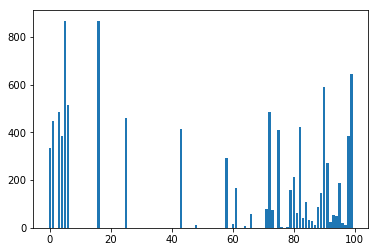

In [77]:
# show the clustering's distribution
index = []
values = []

for i in rbf_cluster_maps:
    index.append(i)
    values.append(len(rbf_cluster_maps[i]))
print(values)
axes = plt.bar(index, values)
plt.show()

In [96]:
def select_k(X):
    for gamma in [10, 1, 0.1, 0.01]:
        for k in [2,4,8,16,32,64]:
            y_pred = SpectralClustering(n_clusters=k,
                                        n_init=10, 
                                        gamma=gamma,
                                        affinity='rbf',
                                        assign_labels ='kmeans').fit_predict(X)
            print("Calinski-Harabasz Score with gamma=", 
            gamma, "n_clusters=", 
            k,"score:", 
            metrics.calinski_harabaz_score(X, y_pred))

#     distance = []
#     k = []
#     #簇的数量
#     for n_clusters in tqdm(range(1, 50, 2)):
#         clustering = SpectralClustering(n_clusters=n_clusters,
#                                 # kmeans epochs
#                                 n_init=10, 
#                                 gamma=1.0,
#                                 affinity='rbf',
# #                                 n_neighbors=10,
#                                 assign_labels ='kmeans',
# #                                 degree=3,
# #                                 coef0=1,
#                                 n_jobs=5).fit(X_minMax)

#         #曼哈顿距离
#         def manhattan_distance(x,y):
#             return np.sum(abs(x-y))

#         distance_sum = 0
#         for i in range(n_clusters):
#             group = clustering.labels_ == i
#             members = X[group,:]
#             for v in members:
#                 distance_sum += manhattan_distance(np.array(v), clustering.cluster_centers_[i])
#         distance.append(distance_sum)
#         k.append(n_clusters)
#     plt.scatter(k, distance)
#     plt.plot(k, distance)
#     plt.xlabel("k")
#     plt.ylabel("distance")
#     plt.show()
select_k(X_minMax)

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Calinski-Harabasz Score with gamma= 10 n_clusters= 2 score: 169.02533939277652
Calinski-Harabasz Score with gamma= 10 n_clusters= 4 score: 4288.472496742024
Calinski-Harabasz Score with gamma= 10 n_clusters= 8 score: 3862.649393420191
Calinski-Harabasz Score with gamma= 10 n_clusters= 16 score: 2580.336941627541
Calinski-Harabasz Score with gamma= 10 n_clusters= 32 score: 1770.9592514741353
Calinski-Harabasz Score with gamma= 10 n_clusters= 64 score: 1185.023788402006
Calinski-Harabasz Score with gamma= 1 n_clusters= 2 score: 9599.714307126162
Calinski-Harabasz Score with gamma= 1 n_clusters= 4 score: 3959.4122029897335
Calinski-Harabasz Score with gamma= 1 n_clusters= 8 score: 3984.2951904406154
Calinski-Harabasz Score with gamma= 1 n_clusters= 16 score: 2416.624203880871
Calinski-Harabasz Score with gamma= 1 n_clusters= 32 score: 1624.7497411571326
Calinski-Harabasz Score with gamma= 1 n_clusters= 64 score: 945.3410829370237
Calinski-Harabasz Score with gamma= 0.1 n_clusters= 2 score

In [97]:
def select_k_silhouette(X):
    for gamma in [10, 1, 0.1, 0.01]:
        for k in [2,4,8,16,32,64]:
            cls = SpectralClustering(n_clusters=k,
                                        n_init=10, 
                                        gamma=gamma,
                                        affinity='rbf',
                                        assign_labels ='kmeans').fit(X)
            print("Silhouette Score with gamma=", 
            gamma, "n_clusters=", 
            k,"score:", 
            metrics.silhouette_score(X, cls.labels_, metric='euclidean'))
select_k_silhouette(X_minMax)

/Users/billywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/graph.py:115: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, np.int)


Silhouette Score with gamma= 10 n_clusters= 2 score: 0.14363682963027383
Silhouette Score with gamma= 10 n_clusters= 4 score: 0.2522665391218191
Silhouette Score with gamma= 10 n_clusters= 8 score: 0.24184253863026137
Silhouette Score with gamma= 10 n_clusters= 16 score: 0.19587225454368726
Silhouette Score with gamma= 10 n_clusters= 32 score: 0.211753423265281
Silhouette Score with gamma= 10 n_clusters= 64 score: 0.2045606312443067
Silhouette Score with gamma= 1 n_clusters= 2 score: 0.4245058662423324
Silhouette Score with gamma= 1 n_clusters= 4 score: 0.28542354183331065
Silhouette Score with gamma= 1 n_clusters= 8 score: 0.2635096934761079
Silhouette Score with gamma= 1 n_clusters= 16 score: 0.18831546964624166
Silhouette Score with gamma= 1 n_clusters= 32 score: 0.17598470020520932
Silhouette Score with gamma= 1 n_clusters= 64 score: 0.1010352301446696
Silhouette Score with gamma= 0.1 n_clusters= 2 score: 0.42450549224981204
Silhouette Score with gamma= 0.1 n_clusters= 4 score: 0.2

In [ ]:
# # poly kernel
# clustering = SpectralClustering(n_clusters=len(seller_maps)**0.5, 
#                                 n_init=10, 
#                                 gamma=1.0,
#                                 affinity='ploy',
# #                                 n_neighbors=10,
#                                 assign_labels ='kmeans',
#                                 degree=3,
#                                 coef0=1,
#                                 n_jobs=5).fit(X)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_

In [ ]:
# # knn kernel
# clustering = SpectralClustering(n_clusters=len(seller_maps)**0.5, 
#                                 n_init=10, 
# #                                 gamma=1.0,
#                                 affinity='nearest_neighbors',
#                                 n_neighbors=10,
#                                 assign_labels ='kmeans',
# #                                 degree=3,
# #                                 coef0=1,
#                                 n_jobs=5).fit(X)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_

In [ ]:
# # cosine kernel
# clustering = SpectralClustering(n_clusters=len(seller_maps)**0.5, 
#                                 n_init=10, 
# #                                 gamma=1.0,
#                                 affinity='cosine',
# #                                 n_neighbors=10,
#                                 assign_labels ='kmeans',
# #                                 degree=3,
# #                                 coef0=1,
#                                 n_jobs=5).fit(X)
# seller_clusters = clustering.labels_
# seller_affinity_matrix = clustering.affinity_matrix_